In [1]:
from typing import Callable

# Sci Math Packages
import math
import numpy as np

np.random.seed(0)  # Fixing the seed for predictable randomness
np.set_printoptions(formatter={"float": lambda x: "{0:0.2f}".format(x)})
import pandas as pd
from scipy import spatial
from scipy.special import entr
from scipy.stats import truncnorm
from sklearn.manifold import TSNE
from sklearn import metrics

# Plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

try:
    import google.colab

    # If import is successful, then we are running in colab
    !mkdir results
    !mkdir simulation_results
    # Load all files from Google Drive to this notebook
    # Import PyDrive and associated libraries.
    # This only needs to be done once per notebook.
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # Authenticate and create the PyDrive client.
    # This only needs to be done once per notebook.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Load all files from my Google Drive to this Jupyter environment
    # https://drive.google.com/open?id=1uQhwdg2QHqRmk3ARIRCvHJDEXOxn822W
    drive.CreateFile({"id": "1uQhwdg2QHqRmk3ARIRCvHJDEXOxn822W"}).GetContentFile(
        "./results/author_features.csv"
    )
    # https://drive.google.com/open?id=1rYuELMib1XNS7ouXwyAWbf3KvrdcsCfq
    drive.CreateFile({"id": "1rYuELMib1XNS7ouXwyAWbf3KvrdcsCfq"}).GetContentFile(
        "./results/hindex.csv"
    )
    # https://drive.google.com/open?id=1W1DwCoIYhZUMCpUTEz_bM9WE4NOOZ-Fj
    drive.CreateFile({"id": "1W1DwCoIYhZUMCpUTEz_bM9WE4NOOZ-Fj"}).GetContentFile(
        "./results/kdd_paper_author_affiliations_for_authors.csv"
    )
    # https://drive.google.com/open?id=12_zWhouELtkBdrnzgAwGy2l1QeFcp7L9
    drive.CreateFile({"id": "12_zWhouELtkBdrnzgAwGy2l1QeFcp7L9"}).GetContentFile(
        "./results/kdd_papers.csv"
    )
    # https://drive.google.com/open?id=1CwIkHGD016oN9E3eMx_yHIdseBJyCPEE
    drive.CreateFile({"id": "1CwIkHGD016oN9E3eMx_yHIdseBJyCPEE"}).GetContentFile(
        "./results/paper_features.csv"
    )
    # Checking that all files are loaded
    !ls results/
except:
    # If not running on colab, import lab_black
    %load_ext lab_black


# Loading all CSV files into memory only once to save time
# Constants
AUTHOR_FEATURE_CSV = pd.read_csv("./results/author_features.csv", index_col=0)
HINDEX_CSV = pd.read_csv("./results/hindex.csv", index_col=0)
KDD_PAPER_AUTHOR_CSV = pd.read_csv(
    "./results/kdd_paper_author_affiliations_for_authors.csv", index_col=0
)
KDD_PAPER_CSV = pd.read_csv("./results/kdd_papers.csv", index_col=0)
PAPER_FEATURE_CSV = pd.read_csv("./results/paper_features.csv", index_col=0)

In [2]:
class Reviewers:
    def __init__(self):
        _features = AUTHOR_FEATURE_CSV.copy(deep=True)
        _h_index = HINDEX_CSV.copy(deep=True)

        # Remove 0 value features
        _features = _features.loc[~(_features == 0).all(axis=1)]
        _indexes = _features.index.values.tolist()
        self.features = _features.to_numpy()
        self.h_index = np.array(
            [int(_h_index[_h_index["0"] == _index]["2"]) for _index in _indexes]
        )
        print(
            f"Reviewer features of size: {self.features.shape}, h index of size {self.h_index.shape}"
        )

    def sample(self, number):
        if number > self.features.shape[0]:
            raise Exception("number too large")
        else:
            _index = np.random.choice(self.features.shape[0], number, replace=False)
            return self.features[_index], self.h_index[_index]

    def plot(self):
        _fig, _ax = plt.subplots(figsize=(6, 4))
        sns.distplot(self.h_index, ax=_ax, kde=False, hist=True, bins=50)
        plt.xlabel("Scholar Research Impact Score (h-index)")
        plt.ylabel("Number of Scholars")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid(which="major")
        plt.show()


class Papers:
    def __init__(self, from_year: int = 2014, to_year: int = 2018):
        _kdd_papers = KDD_PAPER_CSV.copy(deep=True)
        # Filter papers based on year
        _kdd_papers = _kdd_papers[
            np.logical_and(from_year <= _kdd_papers.Year, _kdd_papers.Year <= to_year)
        ]
        # Filter features based on paper ids
        _features = PAPER_FEATURE_CSV.copy(deep=True)
        _features = _features[_features.index.isin(_kdd_papers.PaperId)]
        # Remove 0 value features
        _features = _features.loc[~(_features == 0).all(axis=1)]
        _author_paper = KDD_PAPER_AUTHOR_CSV.copy(deep=True)
        _h_index = HINDEX_CSV.copy(deep=True)

        _indexes = _features.index.values.tolist()

        self.h_index = []
        self.citation = []
        self.year = []
        for _index in _indexes:
            _author_indexes = list(
                _author_paper[_author_paper["PaperId"] == _index]["AuthorId"]
            )
            self.h_index.append(
                [int(_h_index[_h_index["0"] == _x]["2"]) for _x in _author_indexes]
            )
            _paper = _kdd_papers[_kdd_papers["PaperId"] == _index]
            self.citation.append(_paper["CitationCount"].item())
            self.year.append(_paper["Year"].item())

        self.h_index = np.array(self.h_index)
        self.citation = np.array(self.citation)
        self.year = np.array(self.year)
        self.features = _features.to_numpy()
        print(f"Paper features of size: {self.features.shape}")

    def sample(self, number):
        if number > self.features.shape[0]:
            raise Exception("number too large")
        else:
            _index = np.random.choice(self.features.shape[0], number, replace=False)
            return (
                self.features[_index],
                self.h_index[_index],
                self.citation[_index],
                self.year[_index],
            )

    def plot(self):
        average_h_index = np.array([np.average(x) for x in self.h_index])
        _fig, _ax = plt.subplots(figsize=(6, 4))
        sns.distplot(average_h_index, ax=_ax, kde=False, hist=True, bins=100)
        plt.xlabel("Average Author h-index of All KDD Papers")
        plt.ylabel("Number of Papers")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid()
        plt.show()

In [3]:
class Simulation:
    def __init__(self, p_feature, p_h_index, p_citation, p_year, r_feature, r_h_index):
        self.p_feature = p_feature
        self.p_h_index = p_h_index
        self.p_citation = p_citation
        self.p_year = p_year
        self.r_feature = r_feature
        self.r_h_index = r_h_index
        vector_entropy = lambda x: entr(x / x.sum()).sum()
        self.p_entropy = np.array([vector_entropy(x) for x in self.p_feature])

        # Attributes to be defined:
        self.attractive = None
        self.quality = None
        self.likelihood = None
        self.p_balances = None
        self.score = None
        self.review_transfer = None

    def calculate_quality(self, func: Callable[["Simulation"], np.array]):
        self.quality = func(self)

    def calculate_attractive(self, func: Callable[["Simulation"], np.array]):
        self.attractive = func(self)

    def calculate_review_likelihood(self, func: Callable[["Simulation"], np.array]):
        self.likelihood = func(self)

    def calculate_submission_fees(self, func: Callable[["Simulation"], np.array]):
        self.p_balances = func(self)

    def calculate_review_scores(self, func: Callable[["Simulation"], np.array]):
        self.score = func(self)

    def calculate_review_fees(self, func: Callable[["Simulation"], np.array]):
        self.review_transfer = func(self)

    def calculate_final_balance(self):
        self.p_balances = np.add(
            self.p_balances, np.nansum(self.review_transfer, axis=0)
        )

In [4]:
class Visualisation(Simulation):
    def visualise_quality(self):
        _fig, _ax = plt.subplots(figsize=(6, 4))

        sns.distplot(
            np.array(self.quality),
            ax=_ax,
            kde=False,
            hist=True,
            hist_kws={"range": [0, 1]},
            bins=100,
        )
        plt.xlabel("Normalised Paper Quality Score")
        plt.ylabel("Number of Papers")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid(which="major")
        plt.show()

    def visualise_attractive(self):
        _fig, _ax = plt.subplots(figsize=(6, 4))

        sns.distplot(
            np.array(self.attractive),
            ax=_ax,
            kde=False,
            hist=True,
            hist_kws={"range": [0, 1]},
            bins=100,
        )
        plt.xlabel("Normalised Paper Attractive Score")
        plt.ylabel("Number of Papers")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid(which="major")
        plt.show()

    def visualise_score(self):
        _x = self.score.flatten()
        _x = _x[~np.isnan(_x)]
        _fig, _ax = plt.subplots(figsize=(6, 4))
        sns.distplot(
            np.array(_x),
            ax=_ax,
            kde=False,
            hist=True,
            hist_kws={"range": [0, 1]},
            bins=100,
        )
        plt.xlabel("Review Scores")
        plt.ylabel("Number of Reviews")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid(which="major")
        plt.show()

    def visualise_similarity_distributions(self):
        _x1 = self.likelihood.flatten()
        # links that given a score
        _linked = [1 if not np.isnan(x) else x for x in self.score.flatten()]
        _x2 = np.multiply(_x1, _linked)
        _x1 = _x1[np.nonzero(_x1)]
        _x2 = _x2[~np.isnan(_x2)]
        print(np.average(_x1), np.average(_x2))

        _fig, _ax = plt.subplots(figsize=(20, 16))
        sns.distplot(
            np.array(_x1),
            ax=_ax,
            kde=False,
            hist=True,
            hist_kws={"range": [0, 1]},
            bins=100,
        )

        sns.distplot(
            np.array(_x2),
            ax=_ax,
            kde=False,
            hist=True,
            hist_kws={"range": [0, 1]},
            bins=100,
        )

        plt.show()

    def visualise_paper_balances(self):
        _x = self.p_balances.flatten()
        _x = _x[~np.isnan(_x)]
        _fig, _ax = plt.subplots(figsize=(20, 16))

        sns.distplot(np.array(_x), ax=_ax, kde=False, hist=True, bins=20)
        plt.show()

    def visualise_constructive_and_critical_reviews(self):
        _constructive_reviews_map = np.count_nonzero(
            np.greater(self.review_transfer, 0), axis=0
        )

        _critical_reviews_map = np.count_nonzero(
            np.less(self.review_transfer, 0), axis=0
        )

        print(_constructive_reviews_map)

        _max_number_of_reviews = max(
            max(_constructive_reviews_map), max(_critical_reviews_map)
        )

        print(_max_number_of_reviews)

        _constructive = np.array(
            [
                sum(_constructive_reviews_map == x)
                for x in range(_max_number_of_reviews + 1)
            ]
        )
        _critical = np.array(
            [sum(_critical_reviews_map == x) for x in range(_max_number_of_reviews + 1)]
        )
        _classes = np.array(list(range(_max_number_of_reviews + 1)))

        _y = np.arange(_classes.size)
        _y = _y[::-1]
        print(_y)

        _fig, _axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
        _axes[0].barh(
            _y, _constructive, align="center", color="red", alpha=0.6, zorder=10
        )
        _axes[0].set(title="Constructive Reviews")
        _axes[1].barh(_y, _critical, align="center", color="blue", alpha=0.6, zorder=10)
        _axes[1].set(title="Critical Reviews")

        _axes[0].set(yticks=_y, yticklabels=_classes)
        _axes[0].yaxis.tick_right()

        for _ax in _axes.flat:
            _ax.margins(0.03)
            _ax.xaxis.grid(True)
            _ax.set_xscale("log")
            _ax.set_xlim([0, 1000])

        _axes[0].invert_xaxis()

        _fig.tight_layout()
        _fig.subplots_adjust(wspace=0.08)
        plt.show()

    def visualise_review_number(self):
        review_count = np.count_nonzero(~np.isnan(self.score), axis=0)
        reviewer_count = np.count_nonzero(~np.isnan(self.score), axis=1)

        _fig, _axes = plt.subplots(ncols=2, figsize=(10, 4))

        sns.distplot(
            np.array(review_count),
            ax=_axes[0],
            kde=False,
            hist=True,
            bins=len(np.unique(review_count)),
            # hist_kws={"rwidth": 0.75, "edgecolor": "black", "alpha": 1.0},
            hist_kws={"rwidth": 0.75},
        )

        sns.distplot(
            np.array(reviewer_count),
            ax=_axes[1],
            kde=False,
            hist=True,
            bins=len(np.unique(reviewer_count)),
            # hist_kws={"rwidth": 0.75, "edgecolor": "black", "alpha": 1.0},
            hist_kws={"rwidth": 0.75},
        )

        for _ax in _axes.flat:
            _ax.set_ylabel("Number of Papers")
            _ax.yaxis.grid(True)

        _axes[0].set_xlabel("Number of Reviews (Per Paper)")
        _axes[1].set_xlabel("Number of Reviews (Per Reviewer)")
        _axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        _axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
        _fig.subplots_adjust(wspace=0.3)

        print(
            f"Percentage of zero review papers {1 - np.count_nonzero(review_count)/len(review_count)}"
        )
        print(
            f"Percentage of zero review scholars: {1 - np.count_nonzero(reviewer_count)/len(reviewer_count)}"
        )

        plt.show()

# Run Simulation

/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: FutureWarning: `item` has been deprecated and will be removed in a future version


Paper features of size: (1183, 2348)


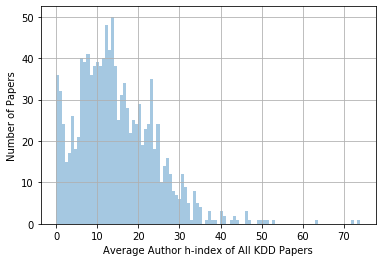

In [5]:
# Load papers
paper_pool = Papers()
paper_feature, paper_h_index, paper_citation, paper_year = paper_pool.sample(
    1000
)  # Number of Submission
paper_pool.plot()

Reviewer features of size: (7075, 2348), h index of size (7075,)


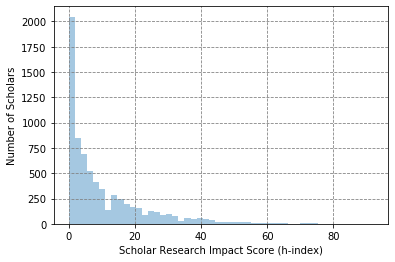

In [6]:
# Load reviewers
reviewer_pool = Reviewers()
reviewer_feature, reviewer_h_index = reviewer_pool.sample(3000)  # Number of Scholars
reviewer_pool.plot()

In [7]:
# The papers and reviewers must be defined before defining the following functions

max_h_index = np.max(reviewer_h_index)
min_h_index = np.min(reviewer_h_index)

max_log_avg_citation = np.max(np.log((paper_citation + 1) / (2020 - paper_year)))
min_log_avg_citation = np.min(np.log((paper_citation + 1) / (2020 - paper_year)))


def f_constant_submission_fee(simulation, fee):
    n_papers = simulation.p_feature.shape[0]
    return np.full((n_papers,), fee)


def f_h_index_based_submission_fee(simulation, fee):
    return [(1 - x) * fee for x in simulation.attractive]


def f_quality(simulation):
    return np.array(
        [
            (
                np.log((simulation.p_citation[_p] + 1) / (2020 - simulation.p_year[_p]))
                - min_log_avg_citation
            )
            / (max_log_avg_citation - min_log_avg_citation)
            for _p in range(simulation.p_feature.shape[0])
        ]
    )


def f_attractive(simulation):
    return np.array(
        [
            (np.average(simulation.p_h_index[_p]) - min_h_index)
            / (max_h_index - min_h_index)
            for _p in range(simulation.p_feature.shape[0])
        ]
    )


def calculate_score(quality, reviewer_hindex):
    _score = np.random.normal(loc=quality, scale=1.0 / (reviewer_hindex + 2), size=1)[0]
    _score = min(1, _score)
    _score = max(0, _score)
    return _score


def f_review_fee(simulation, policy):
    _scores = simulation.score.flatten()
    _scores = _scores[~np.isnan(_scores)]
    _percentiles = [np.percentile(_scores, _x) for _x, _ in policy]
    _balances = [_x for _, _x in policy]

    def calculate_balance(score):
        if np.isnan(score):
            return np.nan
        for _i in range(len(_percentiles)):
            if score <= _percentiles[_i]:
                return _balances[_i]

    return np.array(
        [
            [
                calculate_balance(simulation.score[_r][_p])
                for _p in range(simulation.p_feature.shape[0])
            ]
            for _r in range(simulation.r_feature.shape[0])
        ]
    )


def f_review_fee_h_index(simulation, policy):
    _scores = simulation.score.flatten()
    _scores = _scores[~np.isnan(_scores)]
    _percentiles = [np.percentile(_scores, _x) for _x, _ in policy]
    _balances = [_x for _, _x in policy]

    def calculate_balance(score):
        if np.isnan(score):
            return np.nan
        for _i in range(len(_percentiles)):
            if score <= _percentiles[_i]:
                return _balances[_i]

    return np.array(
        [
            [
                calculate_balance(simulation.score[_r][_p]) * simulation.attractive[_p]
                for _p in range(simulation.p_feature.shape[0])
            ]
            for _r in range(simulation.r_feature.shape[0])
        ]
    )


def f_score_flex_number_of_reviews(simulation: Simulation):
    _n_papers = simulation.p_feature.shape[0]
    _n_reviewers = simulation.r_feature.shape[0]
    _position_array = list(range(_n_papers * _n_reviewers))
    np.random.seed(0)
    _do_review = np.random.rand(*simulation.likelihood.shape) < simulation.likelihood
    _result = np.array(
        [
            [
                calculate_score(simulation.quality[_p], simulation.r_h_index[_r])
                if _do_review[_r][_p]
                else np.nan
                for _p in range(_n_papers)
            ]
            for _r in range(_n_reviewers)
        ]
    )
    print(f"Generated {sum(sum(~np.isnan(_result)))} reviews")
    return _result


# Dynamic way of running the experiments
def f_score_dynamic(simulation: Simulation):
    _n_papers = simulation.p_feature.shape[0]
    _n_reviewers = simulation.r_feature.shape[0]

    if simulation.score is None:
        simulation.score = np.empty((_n_reviewers, _n_papers))
        simulation.score[:] = np.NaN

    _position_array = list(range(_n_papers * _n_reviewers))

    _potential_reviews = (
        np.random.rand(*simulation.likelihood.shape) < simulation.likelihood
    )

    # If score has been assigned previously(reviewed before), we remove them from potential paper review pool
    _potential_reviews = np.logical_and(_potential_reviews, np.isnan(simulation.score))

    _indexes = [
        np.random.choice(np.where(row)[0]) if len(np.where(row)[0]) > 0 else None
        for row in _potential_reviews
    ]

    for _reviewer_idx, _paper_idx in zip(range(_potential_reviews.shape[0]), _indexes):
        if _paper_idx is not None:
            simulation.score[_reviewer_idx][_paper_idx] = calculate_score(
                simulation.quality[_paper_idx]
            )
    print(f"Now have {sum(sum(~np.isnan(simulation.score)))} reviews")
    return simulation.score


def f_similarity(simulation, gamma=None):
    # cdist is calling into optimised C code, no waste on type checking, but no multiprocessing (no need for GPU)
    # broadcast gamma in numpy (optimised C as well)
    return np.multiply(
        (
            1
            - spatial.distance.cdist(
                simulation.p_feature, simulation.r_feature, "cosine"
            )
        ),
        np.zeros(simulation.r_feature.shape[0]) if gamma is None else gamma,
    ).T


def f_token_incentive(
    s: "Simulation", critical_review_fee, contructive_review_fee, alpha=None, theta=0.5
):
    if alpha is None:
        alpha = np.zeros(s.r_feature.shape[0])
    if s.score is None:
        _review_counts = np.ones(s.p_feature.shape[0])
    else:
        _review_counts = (
            np.sum(~np.isnan(s.score), axis=0) + 1
        )  # Broadcast 1 to all elements
    _paper_incentive = np.array(
        [
            (
                -0.5 * np.tanh(8 * (s.quality[_p] - theta))
                + 0.5
                * (critical_review_fee - contructive_review_fee)
                / (critical_review_fee + contructive_review_fee)
            )
            for _p in range(s.p_feature.shape[0])
        ]
    )
    # return np.dot(
    #     alpha.reshape((-1, 1)), (_paper_incentive / _review_counts).reshape((1, -1))

    return np.dot(alpha.reshape((-1, 1)), _paper_incentive.reshape((1, -1)))


def f_reputation_incentive(_simulation, beta=None):
    if beta is None:
        beta = np.zeros(_simulation.r_feature.shape[0])
    incentive = np.array(
        [
            ((_simulation.quality[_p]) ** 2)
            for _p in range(_simulation.p_feature.shape[0])
        ]
    )
    return np.dot(beta.reshape((-1, 1)), incentive.reshape((1, -1)))

In [8]:
def get_statistics(s: "Simulation"):
    number_of_reviews = (~np.isnan(s.score)).sum()

    avg_attractive_0_review_paper = np.average(
        s.attractive[(~np.isnan(s.score)).sum(axis=0) == 0]
    )
    avg_attractive_all_paper = np.average(s.attractive)

    avg_quality_0_review_paper = np.average(
        s.quality[(~np.isnan(s.score)).sum(axis=0) == 0]
    )
    avg_quality_all_paper = np.average(s.quality)

    zero_review_paper_rate = (
        (~np.isnan(s.score)).sum(axis=0) == 0
    ).sum() / s.p_feature.shape[0]

    zero_review_scholar_rate = (
        (~np.isnan(s.score)).sum(axis=1) == 0
    ).sum() / s.r_feature.shape[0]

    statistics = [
        number_of_reviews,
        round(zero_review_paper_rate, 6),
        round(zero_review_scholar_rate, 6),
        round(avg_attractive_0_review_paper, 6),
        round(avg_attractive_all_paper, 6),
        round(avg_quality_0_review_paper, 6),
        round(avg_quality_all_paper, 6),
    ]

    return statistics

In [9]:
# Simulation Parameters:
# number_of_reviews - Parameters to tune
# p_feature, p_h_index, r_feature, r_h_index - Paper and scholar features
# fees - submission fee
# f_quality - function to compute paper quality
# f_similarity - function to compute reviewer and paper simularity
# f_score - function to compute review score
# policy [[negative upperbound, critical review fee], [positive upperbound, constructive review fee]]
_s = Simulation(
    paper_feature,
    paper_h_index,
    paper_citation,
    paper_year,
    reviewer_feature,
    reviewer_h_index,
)

submission_fee = 20
critical_review_fee = 5
contructive_review_fee = 5


# Paper Attractiveness - based on authors' h-index
_s.calculate_attractive(f_attractive)
_s.calculate_quality(f_quality)

# Constant submission fee
_s.calculate_submission_fees(lambda x: f_constant_submission_fee(x, submission_fee))

In [10]:
%%time

# Likelihood

#alpha = np.random.normal(parameters[0], parameters[1], _s.r_feature.shape[0])

results = []
a_step_size = 0.0004
b_step_size = 0.0012

a_std = a_step_size / 4
b_std = b_step_size / 4

g_mean = 0.003
g_std = 0.002 / 4

#a_mean = [0, 0.001, 0.002, 0.003, 0.004]
#b_mean = [0, 0.002, 0.004, 0.006, 0.008]

a_mean = [0, 0.001, 0.002, 0.003]
b_mean = [0, 0.002, 0.004, 0.006]

# theta = 0.45 leads to acceptance rate ~20%
theta = 0.45
_critical_percentile = (_s.quality < theta).sum()/_s.p_feature.shape[0] *100

review_arrays = []
statistics = []

for i in range(len(a_mean)):
    for j in range(len(b_mean)):
        

        alpha = truncnorm((0 - a_mean[i])/a_std,(1 - a_mean[i])/a_std, loc = a_mean[i], scale = a_std).rvs(_s.r_feature.shape[0]) 
        beta = truncnorm((0 - b_mean[j])/b_std,(1 - b_mean[j])/b_std, loc = b_mean[j], scale = b_std).rvs(_s.r_feature.shape[0]) 
        gamma = truncnorm((0 - g_mean)/g_std,(1 - g_mean)/g_std, loc = g_mean, scale = g_std).rvs(_s.r_feature.shape[0]) 


        likelihood_function = lambda x: (np.maximum(0,np.minimum(1,f_similarity(x, gamma) + f_token_incentive(x, critical_review_fee, contructive_review_fee, alpha, theta)+ f_reputation_incentive(x, beta),),))
        _s.calculate_review_likelihood(likelihood_function)
        _s.calculate_review_scores(f_score_flex_number_of_reviews)


        _s.calculate_review_fees(
            lambda x: f_review_fee(
                x, 
                [
                    [_critical_percentile, -critical_review_fee], 
                    [100, contructive_review_fee]
                ]
            )
        )

        # Final balance

        _s.calculate_final_balance()
    
        review_arrays.append(np.count_nonzero(~np.isnan(_s.score), axis=0))
        
        
        
        number_of_reviews = (~np.isnan(_s.score)).sum()
        avg_quality_0_review_paper = np.average(_s.quality[(~np.isnan(_s.score)).sum(axis=0) == 0])
        avg_quality_all_paper = np.average(_s.quality)

        zero_review_paper_rate = ((~np.isnan(_s.score)).sum(axis=0) == 0).sum() / _s.p_feature.shape[0]

        statistics.append([a_mean[i], b_mean[j], number_of_reviews, round(avg_quality_0_review_paper, 6), round(avg_quality_all_paper, 6), round(zero_review_paper_rate, 6)])

Generated 423 reviews
Generated 1151 reviews
Generated 1927 reviews
Generated 2743 reviews
Generated 1173 reviews
Generated 1831 reviews
Generated 2611 reviews
Generated 3406 reviews
Generated 2060 reviews
Generated 2555 reviews
Generated 3314 reviews
Generated 4116 reviews
Generated 2917 reviews
Generated 3334 reviews
Generated 4022 reviews
Generated 4789 reviews
CPU times: user 9min 35s, sys: 4.21 s, total: 9min 39s
Wall time: 9min 9s


In [11]:
_s.__class__ = Visualisation
# _s.visualise_similarity_distributions()
# print(np.sum(_s.likelihood.flatten()[np.nonzero(_s.likelihood.flatten())]))

In [ ]:
_fig, _axes = plt.subplots(len(a_mean), len(b_mean), sharey=True, figsize=(15, 12.5))


x_max = 15
for i in range(len(review_arrays)):
    _ax = _axes[int(i / len(b_mean))][i % len(b_mean)]
    review_count = review_arrays[i]
    sns.distplot(
        np.array(review_count),
        ax=_ax,
        kde=False,
        hist=True,
        # bins=len(np.unique(review_count)),
        bins=np.arange(x_max) - 0.5,
        # hist_kws={"rwidth": 0.75, "edgecolor": "black", "alpha": 1.0},
        hist_kws={"range": [0, x_max], "rwidth": 0.75},
    )

    if i % len(b_mean) == 0:
        _ax.set_ylabel(r"Number of Papers")

    if int(i / len(b_mean)) == len(a_mean) - 1:
        _ax.set_xlabel(r"Number of Reviews (Per Paper)")
    _ax.yaxis.grid(True)

    _ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # _ax.text(2, 600, statistics[i])
    _ax.text(1, 610, r"Number of Reviews: {}".format(statistics[i][2]), fontsize=11)
    _ax.text(
        1,
        510,
        r"Papers with 0 Review: {:.2%}".format(float(statistics[i][5])),
        fontsize=11,
    )
    _ax.text(
        1,
        410,
        r"0 Review Paper Avg Quality: {:.2}".format(float(statistics[i][3])),
        fontsize=11,
    )
    _ax.title.set_text("({})".format(chr(65+i)))
    # _ax.label_outer()
    # _fig.subplots_adjust(wspace=0.3)

plt.tight_layout()
# plt.show()
plt.savefig("review_assignment_distribution.png")

In [13]:
np.mean(_s.quality)

0.3271170001949072

In [22]:
(_s.quality < 0.36).sum() / _s.p_feature.shape[0] * 100

59.9

In [15]:
np.linspace(0, 0.2, 1)

array([0.00])

In [23]:
3 % 5

3

In [26]:
np.mean(_s.score.flatten()[~np.isnan(_s.score.flatten())])

0.33544499787071363